In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from tqdm import tqdm

# model
import lightgbm as lgb

SEED=42
LABEL=None

In [0]:
path = '/content/drive/My Drive/bigcontest2019/'
os.chdir(path)

In [0]:
train_activity = pd.read_csv('data/train/train_activity.csv')
train_combat = pd.read_csv('data/train/train_combat.csv')
train_payment = pd.read_csv('data/train/train_payment.csv')
train_pledge = pd.read_csv('data/train/train_pledge.csv')
train_trade = pd.read_csv('data/train/train_trade.csv')

test1_activity = pd.read_csv('data/test/test1_activity.csv')
test1_combat = pd.read_csv('data/test/test1_combat.csv')
test1_payment = pd.read_csv('data/test/test1_payment.csv')
test1_pledge = pd.read_csv('data/test/test1_pledge.csv')
test1_trade = pd.read_csv('data/test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'data/test/test2_activity.csv')
test2_combat = pd.read_csv(path + 'data/test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'data/test/test2_payment.csv')
test2_pledge = pd.read_csv(path + 'data/test/test2_pledge.csv')
test2_trade = pd.read_csv(path + 'data/test/test2_trade.csv')

train_label = pd.read_csv('data/train/train_label.csv')

In [0]:
class data_transform(object): #
    def __init__(self, data):
        self.data = data
        
    def create_week(self):
        self.data['week'] = (self.data['day']-1)//7 + 1
        return self.data
    
    def activity_transform(self):
        temp_df = self.data
        groupby_dict = defaultdict()
        
        temp_df = pd.get_dummies(temp_df)
        
        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day' or feature == 'char_id':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = 'sum'
        else:        
            temp_df = temp_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
        
        return temp_df
    
    def payment_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'count', 'max', 'std']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def trade_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        groupby_dict2 = defaultdict()
        
        output_df['time'] = output_df['time'].apply(lambda x: str(x)[:2])
        output_df[['time', 'type', 'server']] = output_df[['time', 'type', 'server']].astype(object)
        output_df = pd.get_dummies(output_df)
        output_df2 = output_df.copy()
        
        output_df = output_df.rename(columns={'source_acc_id':'acc_id'})
        output_df2 = output_df2.rename(columns={'target_acc_id':'acc_id'})
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'target_acc_id']:
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
        
        for feature in output_df2.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'source_acc_id']:
                groupby_dict2[feature] = 'nunique'
            else:
                groupby_dict2[feature] = 'sum'
        else:
            output_df2 = output_df2.groupby(['acc_id', 'week']).agg(groupby_dict2).reset_index()
        
        output_df = pd.merge(output_df, output_df2, how='outer', on=['acc_id', 'week'])
        
        return output_df
    
    def combat_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server', 'class', 'level']] = output_df[['server', 'class', 'level']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = ['sum']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def pledge_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server']] = output_df[['server']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'pledge_id']:
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        return output_df
    
    
    
    def under_sampling(self):
        temp_df = self.data
        output_df = pd.DataFrame()
        for week in [1, 2, 3, 4]:
            _, under_sample = train_test_split(temp_df[(temp_df['week']==week) & (temp_df['survival_time']==64)], test_size=0.001, random_state=42, shuffle=True, 
                                               stratify=temp_df.loc[(temp_df['week']==week) & (temp_df['survival_time']==64), 'day'])
            output_df = pd.concat([output_df, under_sample]).reset_index(drop=True)
        
        return output_df
    
    def under_sampling2(self):
        temp_df = self.data
        _, under_sample = train_test_split(temp_df[(temp_df['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)
#                                            stratify=temp_df.loc[(temp_df['survival_time']==64), 'daynunique'])
        
        return under_sample

# survival time

## train

### acitivity

In [0]:
transform = data_transform(train_activity)
transform.create_week()
train = transform.activity_transform()

In [16]:
train.head()

,acc_id,week,day,char_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,server_aa,server_ab,server_ac,server_ad,server_ae,server_af,server_ag,server_ah,server_ai,server_aj,server_ak,server_al,server_am,server_an,server_ao,server_ap,server_aq,server_ar,server_as,server_at,server_au,server_av,server_aw,server_ax,server_ay,server_az,server_bb,server_bc,server_bd,server_bg,server_bi,server_bj,server_bk,server_bl,server_bm,server_bn,server_bo,server_bp,server_br,server_bs
0,2,1,7,1,22.919696,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,21.332888,0.072034,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2,7,1,22.980553,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,21.289547,-0.278344,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,3,7,1,22.659883,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,20.942232,-0.064357,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,4,7,1,22.973531,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,21.336087,0.261921,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2,2,1,0.589845,0.310229,0.359297,0.0,0.0,2,0.0,0.0,0.0,0.0,0.000000,0.009910,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### payment

In [0]:
transform = data_transform(train_payment)
transform.create_week()
train = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(train_trade)
trandform.create_week()
train = trandform.trade_transform()

### combat

In [0]:
trandform = data_transform(train_combat)
trandform.create_week()
train = trandform.combat_transform()

### pledge

In [0]:
trandform = data_transform(train_pledge)
trandform.create_week()
train = trandform.pledge_transform()

## test

### activity

In [0]:
transform = data_transform(test1_activity)
transform.create_week()
test1 = transform.activity_transform()

transform = data_transform(test2_activity)
transform.create_week()
test2 = transform.activity_transform()

### payment

In [0]:
transform = data_transform(test1_payment)
transform.create_week()
test1 = transform.payment_transform()

transform = data_transform(test2_payment)
transform.create_week()
test2 = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(test1_trade)
trandform.create_week()
test1 = trandform.trade_transform()

trandform = data_transform(test2_trade)
trandform.create_week()
test2 = trandform.trade_transform()

### combat

In [0]:
trandform = data_transform(test1_combat)
trandform.create_week()
test1 = trandform.combat_transform()

trandform = data_transform(test2_combat)
trandform.create_week()
test2 = trandform.combat_transform()

### pledge

In [0]:
trandform = data_transform(test1_pledge)
trandform.create_week()
test1 = trandform.pledge_transform()

trandform = data_transform(test2_pledge)
trandform.create_week()
test2 = trandform.pledge_transform()

## model

In [0]:
class model(object):
    def __init__(self, train_data, train_label, test1_data, test2_data, kind):
        self.train_data = train_data.fillna(0)
        self.train_label = train_label
        self.test1_data = test1_data.fillna(0)
        self.test2_data = test2_data.fillna(0)
        self.features_ = train_data.columns[train_data.columns.isin(list(set(train_data.columns) & set(test1_data.columns) & set(test2_data.columns)))].drop(['acc_id', 'week'])
        self.kind = kind
        
    def labeling(self):
        self.train_data = pd.merge(self.train_data, self.train_label[['acc_id', 'survival_time']], how='left', on='acc_id')
        self.train_data = self.train_data.dropna()
        for week in range(1, 5):
            self.train_data.loc[train['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
        
    def under_sampling(self):
        all_week_under_sample = pd.DataFrame()
        for week in range(1, 5):
            if self.kind == 'activity':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True, 
                                                   stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'day'])
            elif self.kind == 'payment':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)
                
            elif self.kind == 'trade':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                  stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), ['day_x', 'day_y']])
            elif self.kind == 'combat':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                  stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'daynunique'])
            elif self.kind == 'pledge':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                  stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'daynunique'])
                
            all_week_under_sample = pd.concat([all_week_under_sample, under_sample]).reset_index(drop=True)
        else:
            self.train_data = pd.concat([self.train_data[self.train_data['survival_time']!=64], all_week_under_sample]).reset_index(drop=True)
            
    def st_lgb_model(self, params, iteration, seed):
        LABEL='survival_time'
        train_df, valid_df = train_test_split(self.train_data, test_size=0.2, random_state=seed, shuffle=True, stratify=self.train_data[['week', LABEL]])
        
        trn_label = train_df[LABEL] - 1
        val_label = valid_df[LABEL] - 1
        ttt = lgb.Dataset(train_df[self.features_], label=trn_label)
        vvv = lgb.Dataset(valid_df[self.features_], label=val_label)

        lgb_model = lgb.train(params, ttt, iteration, valid_sets = [ttt, vvv], early_stopping_rounds = 50, verbose_eval=100)
        self.st_lgb_model = lgb_model
        
        preds_st = lgb_model.predict(self.test1_data.loc[self.test1_data['week']==4, self.features_].fillna(0))
        preds_st = np.argmax(preds_st, axis=1)+1

        preds_st2 = lgb_model.predict(self.test2_data.loc[self.test2_data['week']==4, self.features_].fillna(0))
        preds_st2 = np.argmax(preds_st2, axis=1)+1
        
        preds_st = pd.concat([self.test1_data.loc[self.test1_data['week']==4, 'acc_id'].reset_index(drop=True), pd.DataFrame(preds_st, columns=['survival_time'])], 1)
        preds_st2 = pd.concat([self.test2_data.loc[self.test2_data['week']==4, 'acc_id'].reset_index(drop=True), pd.DataFrame(preds_st2, columns=['survival_time'])], 1)
    
        return preds_st, preds_st2
    
    def feature_importance(self):
        feature_imp = pd.DataFrame(sorted(zip(self.st_lgb_model.feature_importance(), self.features_)), columns=['Value','Feature'])
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.show()

In [150]:
PARAMS = {
    'objective':'multiclass',
    'num_class':64,
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'seed':SEED
}

# 주의!! model object 마지막 kinds arguments 명시해줄것!!
model_ = model(train, train_label, test1, test2, 'payment')
model_.labeling()
model_.under_sampling()
preds_st, preds_st2 = model_.st_lgb_model(PARAMS, 5000, SEED)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 3.73633	valid_1's multi_logloss: 3.94872
Early stopping, best iteration is:
[106]	training's multi_logloss: 3.72545	valid_1's multi_logloss: 3.94817


In [153]:
preds_st

,acc_id,survival_time
0,7,9
1,16,9
2,22,29
3,39,36
4,51,29
5,55,29
6,70,29
7,83,29
8,87,23
9,109,29


In [0]:
path = '/content/drive/My Drive/bigcontest2019/'
submission_path = path + 'scripts/model/metrics/nes_inference/'

# preds_st.to_csv(submission_path + 'activity1_predict.csv' ,index=False) 
# preds_st2.to_csv(submission_path + 'activity2_predict.csv' ,index=False) 
# Early stopping, best iteration is: [618]	training's multi_logloss: 2.25555	valid_1's multi_logloss: 3.39758

# preds_st.to_csv(submission_path + 'payment1_predict.csv',index=False) 
# preds_st2.to_csv(submission_path + 'payment2_predict.csv',index=False) 
# Early stopping, best iteration is: [106]	training's multi_logloss: 3.72545	valid_1's multi_logloss: 3.94817

# preds_st.to_csv(submission_path + 'trade1_predict.csv',index=False) 
# preds_st2.to_csv(submission_path + 'trade2_predict.csv',index=False) 
# Early stopping, best iteration is: [170]	training's multi_logloss: 3.08494	valid_1's multi_logloss: 3.94438

# preds_st.to_csv(submission_path + 'combat1_predict.csv',index=False) 
# preds_st2.to_csv(submission_path + 'combat2_predict.csv',index=False) 
# Early stopping, best iteration is: [406]	training's multi_logloss: 2.7861	valid_1's multi_logloss: 3.5866

# preds_st.to_csv(submission_path + 'pledge1_predict.csv',index=False) 
# preds_st2.to_csv(submission_path + 'pledge2_predict.csv',index=False) 
# Early stopping, best iteration is: [607]	training's multi_logloss: 2.0838	valid_1's multi_logloss: 3.32276

In [0]:
preds_act = pd.read_csv(submission_path + 'activity1_predict.csv')
preds_act2 = pd.read_csv(submission_path + 'activity1_predict.csv')

preds_pay = pd.read_csv(submission_path + 'payment1_predict.csv')
preds_pay2 = pd.read_csv(submission_path + 'payment2_predict.csv')

preds_tra = pd.read_csv(submission_path + 'trade1_predict.csv')
preds_tra2 = pd.read_csv(submission_path + 'trade2_predict.csv')

preds_com = pd.read_csv(submission_path + 'combat1_predict.csv')
preds_com2 = pd.read_csv(submission_path + 'combat2_predict.csv')

preds_ple = pd.read_csv(submission_path + 'pledge1_predict.csv')
preds_ple2 = pd.read_csv(submission_path + 'pledge2_predict.csv')

In [136]:
preds_com.describe()

,acc_id,survival_time
count,20000.000000,20000.000000
mean,64697.176800,29.667900
std,37934.624602,16.503791
min,7.000000,1.000000
25%,31275.500000,22.000000
50%,64604.000000,29.000000
75%,97956.250000,36.000000
max,130474.000000,64.000000


In [0]:
preds_act = preds_act.rename(columns={'survival_time': 'act_survival_time'})
preds_act2 = preds_act2.rename(columns={'survival_time': 'act_survival_time'})

preds_pay = preds_pay.rename(columns={'survival_time': 'pay_survival_time'})
preds_pay2 = preds_pay2.rename(columns={'survival_time': 'pay_survival_time'})

preds_tra = preds_tra.rename(columns={'survival_time': 'tra_survival_time'})
preds_tra2 = preds_tra2.rename(columns={'survival_time': 'tra_survival_time'})

preds_com = preds_com.rename(columns={'survival_time': 'com_survival_time'})
preds_com2 = preds_com2.rename(columns={'survival_time': 'com_survival_time'})

preds_ple = preds_ple.rename(columns={'survival_time': 'ple_survival_time'})
preds_ple2 = preds_ple2.rename(columns={'survival_time': 'ple_survival_time'})

In [0]:
preds_all = preds_act.merge(preds_pay, on = 'acc_id', how = 'left').merge(
    preds_tra, on = 'acc_id', how = 'left').merge(
    preds_com, on = 'acc_id', how = 'left').merge(
    preds_ple, on = 'acc_id', how = 'left')

preds_all2 = preds_act.merge(preds_pay2, on = 'acc_id', how = 'left').merge(
    preds_tra2, on = 'acc_id', how = 'left').merge(
    preds_com2, on = 'acc_id', how = 'left').merge(
    preds_ple2, on = 'acc_id', how = 'left')

preds_all.to_csv(submission_path + 'preds_all.csv',index=False) 
preds_all2.to_csv(submission_path + 'preds_all2.csv',index=False)

In [146]:
preds_tra.describe()

,acc_id,survival_time
count,29495.000000,29495.000000
mean,65028.915884,33.028751
std,37541.491198,13.258868
min,2.000000,1.000000
25%,32456.500000,29.000000
50%,64806.000000,29.000000
75%,97490.000000,36.000000
max,130474.000000,64.000000


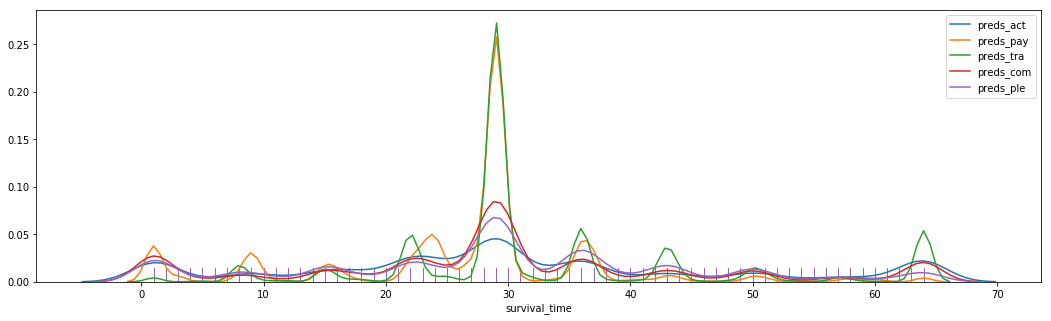

In [105]:
# import numpy as np
# import pandas as pd
# from sklearn.datasets import load_iris
# import seaborn as sns

plt.figure(figsize=(18,5))

sns.distplot(preds_act, hist=False, rug=True, label="preds_act")
sns.distplot(preds_pay, hist=False, rug=True, label="preds_pay")
sns.distplot(preds_tra, hist=False, rug=True, label="preds_tra")
sns.distplot(preds_com, hist=False, rug=True, label="preds_com")
sns.distplot(preds_ple, hist=False, rug=True, label="preds_ple")

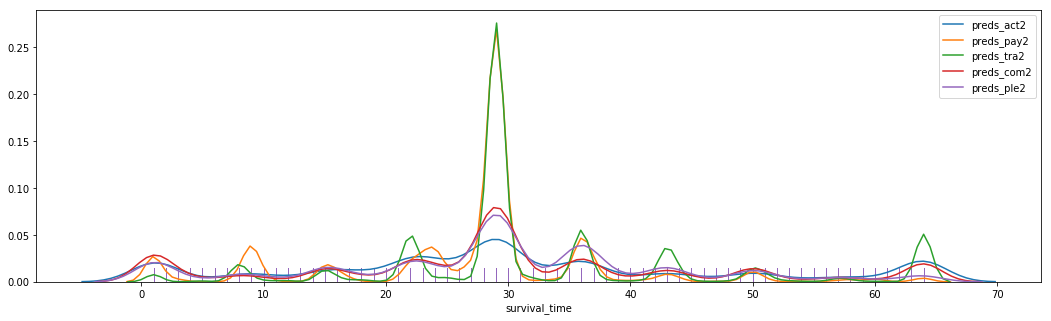

In [106]:
# import numpy as np
# import pandas as pd
# from sklearn.datasets import load_iris
# import seaborn as sns

plt.figure(figsize=(18,5))

sns.distplot(preds_act2, hist=False, rug=True, label="preds_act2")
sns.distplot(preds_pay2, hist=False, rug=True, label="preds_pay2")
sns.distplot(preds_tra2, hist=False, rug=True, label="preds_tra2")
sns.distplot(preds_com2, hist=False, rug=True, label="preds_com2")
sns.distplot(preds_ple2, hist=False, rug=True, label="preds_ple2")

# amount spent

In [0]:
train_label['amount_spent'] = np.round(train_label['amount_spent'], 5)

In [0]:
train_label[train_label['survival_time']!=64]

# submission

In [0]:
test1_pred = pd.concat([test1_week['acc_id'], pd.DataFrame(preds, columns=['survival_time']), pd.DataFrame(preds_spent*25, columns=['amount_spent'])], 1)
test1_pred.to_csv('/content/test1_predict.csv', index=False)

In [0]:
test2_pred = pd.concat([test2_week['acc_id'], pd.DataFrame(preds2, columns=['survival_time']), pd.DataFrame(preds2_spent*10, columns=['amount_spent'])], 1)
test2_pred.to_csv('/content/test2_predict.csv', index=False)

In [0]:
test1_pred = pd.concat([test1[test1['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st, columns=['survival_time']), pd.DataFrame(preds_spent, columns=['amount_spent'])], 1)
test1_pred.to_csv('/content/test1_predict.csv', index=False)

In [0]:
test2_pred = pd.concat([test2[test2['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st2, columns=['survival_time']), pd.DataFrame(preds_spent2, columns=['amount_spent'])], 1)
test2_pred.to_csv('/content/test2_predict.csv', index=False)